In [18]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

#  Завантаження даних
print("Завантаження output.csv...")
df = pd.read_csv("output.csv")

# Підготовка ознак
features = [
    'position_x', 'position_z', 'health', 'armor', 'weapon_level',
    'distance_to_enemy', 'num_enemies_nearby', 'num_allies_nearby',
    'distance_to_nearest_ally', 'enemy_health_avg_nearby',
    'enemy_weapon_level_max', 'power_ratio', 'nearby_pressure',
    'is_enemy_dominant', 'is_in_range_to_attack', 'total_survivability'
]
target = 'action'

X = df[features].values
y = df[target].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Визначення MLP моделі
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )

    def forward(self, x):
        return self.model(x)

input_dim = X.shape[1]
output_dim = 3  # 3 класи дій

model = MLP(input_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Навчання
epochs = 10
for epoch in range(epochs):
    model.train()
    inputs = torch.tensor(X_train, dtype=torch.float32)
    targets = torch.tensor(y_train, dtype=torch.long)

    outputs = model(inputs)
    loss = criterion(outputs, targets)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# ---------- 5. Оцінка ---------- #
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_pred = model(X_test_tensor)
    y_pred_labels = torch.argmax(y_pred, dim=1).numpy()

acc = accuracy_score(y_test, y_pred_labels)
print(f"\n📊 Точність MLP моделі: {acc:.4f}")


Завантаження output.csv...
Epoch 1/10, Loss: 1.1612
Epoch 2/10, Loss: 1.1394
Epoch 3/10, Loss: 1.1181
Epoch 4/10, Loss: 1.0973
Epoch 5/10, Loss: 1.0768
Epoch 6/10, Loss: 1.0567
Epoch 7/10, Loss: 1.0369
Epoch 8/10, Loss: 1.0173
Epoch 9/10, Loss: 0.9979
Epoch 10/10, Loss: 0.9786

📊 Точність MLP моделі: 0.9163


Завантаження output.csv...
Episode 1/100, Avg reward: 4.288, ε: 0.490
Episode 2/100, Avg reward: 4.090, ε: 0.480
Episode 3/100, Avg reward: 4.693, ε: 0.471
Episode 4/100, Avg reward: 4.765, ε: 0.461
Episode 5/100, Avg reward: 4.966, ε: 0.452
Episode 6/100, Avg reward: 5.023, ε: 0.443
Episode 7/100, Avg reward: 5.067, ε: 0.434
Episode 8/100, Avg reward: 5.364, ε: 0.425
Episode 9/100, Avg reward: 5.148, ε: 0.417
Episode 10/100, Avg reward: 5.173, ε: 0.409
Episode 11/100, Avg reward: 5.466, ε: 0.400
Episode 12/100, Avg reward: 5.676, ε: 0.392
Episode 13/100, Avg reward: 5.538, ε: 0.385
Episode 14/100, Avg reward: 5.578, ε: 0.377
Episode 15/100, Avg reward: 5.647, ε: 0.369
Episode 16/100, Avg reward: 5.612, ε: 0.362
Episode 17/100, Avg reward: 5.682, ε: 0.355
Episode 18/100, Avg reward: 5.931, ε: 0.348
Episode 19/100, Avg reward: 6.072, ε: 0.341
Episode 20/100, Avg reward: 6.061, ε: 0.334
Episode 21/100, Avg reward: 5.722, ε: 0.327
Episode 22/100, Avg reward: 5.679, ε: 0.321
Episode 23/100

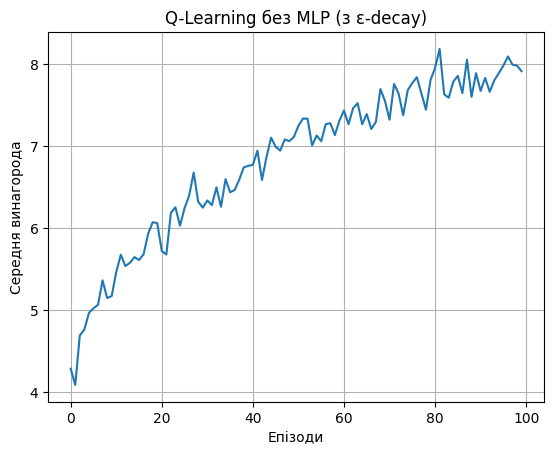

In [11]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import defaultdict

# Завантаження даних
print("Завантаження output.csv...")
df = pd.read_csv("output.csv")

# Підготовка ознак
features = [
    'position_x', 'position_z', 'health', 'armor', 'weapon_level',
    'distance_to_enemy', 'num_enemies_nearby', 'num_allies_nearby',
    'distance_to_nearest_ally', 'enemy_health_avg_nearby',
    'enemy_weapon_level_max', 'power_ratio', 'nearby_pressure',
    'is_enemy_dominant', 'is_in_range_to_attack', 'total_survivability'
]
target = 'action'

X = df[features].values
y = df[target].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test, X_train_index, X_test_index = train_test_split(
    X, y, df.index, test_size=0.2, random_state=42)

# Q-Learning
def state_to_key(state):
    return tuple(np.round(state, 3))

Q = defaultdict(lambda: np.zeros(3))  # 3 дії

gamma = 0.95
alpha = 0.1
epsilon = 0.5
episodes = 100
rewards = []

train_rows = df.iloc[X_train_index].reset_index(drop=True)
train_states = X_train

for episode in range(episodes):
    total_reward = 0
    epsilon = max(0.05, epsilon * 0.98)

    for _ in range(len(train_states)):
        i = random.randint(0, len(train_states) - 2)
        state = train_states[i]
        next_state = train_states[i + 1]
        state_key = state_to_key(state)
        next_key = state_to_key(next_state)
        row = train_rows.iloc[i]

        if random.uniform(0, 1) < epsilon:
            action = random.randint(0, 2)
        else:
            action = np.argmax(Q[state_key])

        reward = 0
        if action == row['action']:
            if row['result'] == 'hit':
                reward += 1
            if row['result'] == 'killed':
                reward += 10
            if row['alive'] == 0:
                reward -= 10
            if row['result'] == 'miss' and row['alive'] == 1:
                reward -= 1
            if 'victory' in row and row['victory'] == 1:
                reward += 50
        else:
            reward -= 2

        total_reward += reward

        Q[state_key][action] += alpha * (
            reward + gamma * np.max(Q[next_key]) - Q[state_key][action]
        )

    avg_reward = total_reward / len(train_states)
    rewards.append(avg_reward)
    print(f"Episode {episode+1}/{episodes}, Avg reward: {avg_reward:.3f}, ε: {epsilon:.3f}")

# Оцінка точності
y_pred_q = []
for x in X_test:
    state_key = state_to_key(x)
    if state_key in Q:
        y_pred_q.append(np.argmax(Q[state_key]))
    else:
        y_pred_q.append(random.randint(0, 2))

acc_q = accuracy_score(y_test, y_pred_q)
print(f"\n📊 Точність чистого Q-learning: {acc_q:.4f}")

# Графік винагороди
plt.plot(range(episodes), rewards)
plt.xlabel("Епізоди")
plt.ylabel("Середня винагорода")
plt.title("Q-Learning без MLP (з ε-decay)")
plt.grid(True)
plt.show()

In [25]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Завантаження та підготовка даних
df = pd.read_csv("output.csv")

# Створення агрегованих ознак (якщо ще не створені)
if 'power_ratio' not in df.columns:
    df['power_ratio'] = (df['health'] + df['armor']) / (df['enemy_health_avg_nearby'] + 1)
    df['nearby_pressure'] = df['num_enemies_nearby'] - df['num_allies_nearby']
    df['is_enemy_dominant'] = (df['enemy_weapon_level_max'] > df['weapon_level']).astype(int)
    df['is_in_range_to_attack'] = (df['distance_to_enemy'] < 0.5).astype(int)
    df['total_survivability'] = df['health'] + df['armor']

# Підготовка ознак
features = [
    'position_x', 'position_z', 'health', 'armor', 'weapon_level',
    'distance_to_enemy', 'num_enemies_nearby', 'num_allies_nearby',
    'distance_to_nearest_ally', 'enemy_health_avg_nearby', 'enemy_weapon_level_max',
    'power_ratio', 'nearby_pressure', 'is_enemy_dominant',
    'is_in_range_to_attack', 'total_survivability'
]
X = df[features]
y = df['action']  # 0 — стоїть, 1 — рухається, 2 — атакує

# Масштабування
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#  Поділ на train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Навчання Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Оцінка
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Стоїть", "Рухається", "Атакує"], yticklabels=["Стоїть", "Рухається", "Атакує"])
plt.xlabel("Прогноз")
plt.ylabel("Справжнє")
plt.title("Confusion Matrix для Random Forest")
plt.show()

✅ Accuracy: 0.788

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.87      0.84       682
           1       0.78      0.78      0.78       671
           2       0.76      0.71      0.73       647

    accuracy                           0.79      2000
   macro avg       0.79      0.79      0.79      2000
weighted avg       0.79      0.79      0.79      2000


📉 Confusion Matrix:
 [[593  30  59]
 [ 59 524  88]
 [ 71 117 459]]


Завантаження output.csv...
Epoch 1/5, Loss: 1.0291
Epoch 2/5, Loss: 1.0098
Epoch 3/5, Loss: 0.9906
Epoch 4/5, Loss: 0.9717
Epoch 5/5, Loss: 0.9528

📊 Точність MLP до Q-learning: 0.9203
Episode 1/50, Avg reward: 8.030, ε: 0.490
Episode 2/50, Avg reward: 8.301, ε: 0.480
Episode 3/50, Avg reward: 7.604, ε: 0.471
Episode 4/50, Avg reward: 7.915, ε: 0.461
Episode 5/50, Avg reward: 8.138, ε: 0.452
Episode 6/50, Avg reward: 8.261, ε: 0.443
Episode 7/50, Avg reward: 8.117, ε: 0.434
Episode 8/50, Avg reward: 8.053, ε: 0.425
Episode 9/50, Avg reward: 8.161, ε: 0.417
Episode 10/50, Avg reward: 8.325, ε: 0.409
Episode 11/50, Avg reward: 8.040, ε: 0.400
Episode 12/50, Avg reward: 8.464, ε: 0.392
Episode 13/50, Avg reward: 8.222, ε: 0.385
Episode 14/50, Avg reward: 8.371, ε: 0.377
Episode 15/50, Avg reward: 8.579, ε: 0.369
Episode 16/50, Avg reward: 8.387, ε: 0.362
Episode 17/50, Avg reward: 8.624, ε: 0.355
Episode 18/50, Avg reward: 8.289, ε: 0.348
Episode 19/50, Avg reward: 8.254, ε: 0.341
Episode

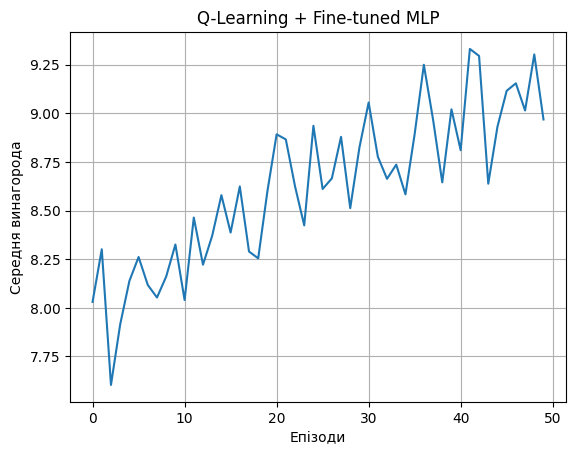

In [24]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from collections import defaultdict

# Завантаження даних
print("Завантаження output.csv...")
df = pd.read_csv("output.csv")

# Підготовка даних
features = [
    'position_x', 'position_z', 'health', 'armor', 'weapon_level',
    'distance_to_enemy', 'num_enemies_nearby', 'num_allies_nearby',
    'distance_to_nearest_ally', 'enemy_health_avg_nearby',
    'enemy_weapon_level_max', 'power_ratio', 'nearby_pressure',
    'is_enemy_dominant', 'is_in_range_to_attack', 'total_survivability'
]
target = 'action'

X = df[features].values
y = df[target].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test, X_train_index, X_test_index = train_test_split(
    X, y, df.index, test_size=0.2, random_state=42)

# MLP модель
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )

    def forward(self, x):
        return self.model(x)

input_dim = X.shape[1]
output_dim = 3  # 0 = стояти, 1 = рухатись, 2 = атакувати

model = MLP(input_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Навчання MLP
epochs = 5
for epoch in range(epochs):
    model.train()
    inputs = torch.tensor(X_train, dtype=torch.float32)
    targets = torch.tensor(y_train, dtype=torch.long)

    outputs = model(inputs)
    loss = criterion(outputs, targets)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

#Оцінка точності MLP
model.eval()
with torch.no_grad():
    y_pred_mlp = model(torch.tensor(X_test, dtype=torch.float32))
    y_pred_labels = torch.argmax(y_pred_mlp, dim=1).numpy()
    acc_before = accuracy_score(y_test, y_pred_labels)
    print(f"\n📊 Точність MLP до Q-learning: {acc_before:.4f}")

# Q-Learning
def state_to_key(state):
    return tuple(np.round(state, 3))

Q = defaultdict(lambda: np.zeros(output_dim))

#  Ініціалізація Q-таблиці прогнозами MLP
with torch.no_grad():
    for i in range(len(X_train)):
        state = X_train[i]
        state_key = state_to_key(state)
        logits = model(torch.tensor(state, dtype=torch.float32)).numpy()
        Q[state_key] = logits

#  Q-learning

gamma = 0.95
alpha = 0.1
epsilon = 0.5
episodes = 50
rewards = []

train_rows = df.iloc[X_train_index].reset_index(drop=True)
train_states = X_train

for episode in range(episodes):
    total_reward = 0
    epsilon = max(0.05, epsilon * 0.98)

    for _ in range(len(train_states)):
        i = random.randint(0, len(train_states) - 2)
        state = train_states[i]
        next_state = train_states[i + 1]
        state_key = state_to_key(state)
        next_key = state_to_key(next_state)
        row = train_rows.iloc[i]

        if random.uniform(0, 1) < epsilon:
            action = random.randint(0, output_dim - 1)
        else:
            action = np.argmax(Q[state_key])

        reward = 0
        if action == row['action']:
            reward += 3
        if row['result'] == 'hit':
            reward += 1
        if row['result'] == 'killed':
            reward += 10
        if row['alive'] == 0:
            reward -= 10
        if row['result'] == 'miss' and row['alive'] == 1:
            reward -= 1
        if 'victory' in row and row['victory'] == 1:
            reward += 50
        if action != row['action']:
            reward -= 2

        total_reward += reward

        Q[state_key][action] = Q[state_key][action] + alpha * (
            reward + gamma * np.max(Q[next_key]) - Q[state_key][action]
        )

    avg_reward = total_reward / len(train_states)
    rewards.append(avg_reward)
    print(f"Episode {episode+1}/{episodes}, Avg reward: {avg_reward:.3f}, ε: {epsilon:.3f}")

# Fine-tuning MLP на основі Q-таблиці
fine_epochs = 3
model.train()
fine_optimizer = optim.Adam(model.parameters(), lr=0.0005)

states_for_ft = torch.tensor(X_train, dtype=torch.float32)
targets_for_ft = torch.tensor(
    [np.argmax(Q[state_to_key(s)]) for s in X_train],
    dtype=torch.long
)

for epoch in range(fine_epochs):
    outputs = model(states_for_ft)
    loss = criterion(outputs, targets_for_ft)

    fine_optimizer.zero_grad()
    loss.backward()
    fine_optimizer.step()
    print(f"[Fine-tune] Epoch {epoch+1}/{fine_epochs}, Loss: {loss.item():.4f}")

# Оцінка після Fine-tuned Q-learning
model.eval()
with torch.no_grad():
    final_preds = model(torch.tensor(X_test, dtype=torch.float32))
    y_final_labels = torch.argmax(final_preds, dim=1).numpy()
    acc_after = accuracy_score(y_test, y_final_labels)
    print(f"📊 Точність після Q-learning + Fine-tuning MLP: {acc_after:.4f}\n")

# Графік винагороди
plt.plot(range(episodes), rewards)
plt.xlabel("Епізоди")
plt.ylabel("Середня винагорода")
plt.title("Q-Learning + Fine-tuned MLP")
plt.grid(True)
plt.show()
